In [1]:
import os
import pickle
import torch
import numpy as np
import pandas as pd

import warnings
import matplotlib
import matplotlib.pyplot as plt
import gc
from PIL import Image
from tqdm import tqdm
from skimage.transform import AffineTransform, warp
from torch.utils.data import DataLoader

from utils.utils import create_folder, load_config
from dataloaders.presets import PresetTransform
from dataloaders import *  
from models import *
from XAI import *


warnings.filterwarnings('ignore')

# XAI CLASSIC

In [7]:
def to_uint8(m): return (np.clip(m, 0, 1)*255).round().astype(np.uint8)

In [2]:
device = 'cuda'
folder = ''
model = 'VGGFace'

path_experiments = f'experiments\\{folder}\\{model}'
path_masks = os.path.join(path_experiments, 'xai_masks')
path_mean_XAI = os.path.join(path_experiments, 'xai_masks', 'mean_masks')

path_mesh = 'Datasets\\DatasetFaces\\Landmarks'

In [3]:
filename = 'results.pkl'

with open(os.path.join(path_experiments,filename), 'rb') as f:
    daata = pickle.load(f)
    daata.pop('embeddings', None)  # Remove embeddings if present
    dataframe = pd.DataFrame(daata)

In [4]:
dataframe

,fold,img_names,probs,preds,logits,labels
0,0,Datasets\Folds\0\Test\ID167_iCOPE_S15_pain.jpg,0.890739,1,2.098312,1
1,0,Datasets\Folds\0\Test\ID168_iCOPE_S15_pain.jpg,0.355930,0,-0.593075,1
2,0,Datasets\Folds\0\Test\ID169_iCOPE_S15_pain.jpg,0.932190,1,2.620822,1
3,0,Datasets\Folds\0\Test\ID170_iCOPE_S15_pain.jpg,0.965974,1,3.346001,1
4,0,Datasets\Folds\0\Test\ID171_iCOPE_S15_nopain.jpg,0.422020,0,-0.314485,0
...,...,...,...,...,...,...
516,9,Datasets\Folds\9\Test\ID378_UNIFESP_S35_pain.jpg,0.982374,1,4.020574,1
517,9,Datasets\Folds\9\Test\ID379_UNIFESP_S35_pain.jpg,0.371620,0,-0.525274,1
518,9,Datasets\Folds\9\Test\ID380_UNIFESP_S35_pain.jpg,0.329404,0,-0.710882,1
519,9,Datasets\Folds\9\Test\ID381_UNIFESP_S35_pain.jpg,0.957419,1,3.112828,1


In [5]:
create_folder(path_masks)
create_folder(path_mean_XAI)

In [10]:

# Define your batch size (adjust based on your memory/GPU capacity)
BATCH_SIZE = 16

for exp in os.listdir(path_experiments):
    # Skip non-experiment folders/files.
    if any(ext in exp for ext in ['.pkl', 'masks', '.png', '.pdf']):
        continue

    # Load model and configuration.
    path_model = os.path.join(path_experiments, exp, 'Model', 'best_model.pt')
    path_yaml  = os.path.join(path_experiments, exp, 'Model', 'config.yaml')
    config     = load_config(path_yaml)
    test_path  = config['path_test']

    # Set up the model, transforms, and attribution objects based on experiment type.
    if "NCNN" in exp:
        model = NCNN().to(device)
        img_size = 120
        transform = PresetTransform("NCNN").transforms
        ig      = IntegratedGradients(model, device=device)
        gradcam = GradCAM(model, model.merge_branch[0], device=device)
    elif "VGGFace" in exp:
        model = VGGFace().to(device)
        img_size = 224
        transform = PresetTransform("VGGFace").transforms
        ig      = IntegratedGradients(model, device=device)
        gradcam = GradCAM(model, model.VGGFace.features.conv5_3, device=device)
    elif "ViT" in exp:
        model = ViT().to(device)
        img_size = 224
        transform = PresetTransform("ViT").transforms
        ig      = IntegratedGradients(model, device=device)
        gradcam = GradCAM(model,
                          model.ViT.encoder.layers.encoder_layer_11.ln_1,
                          device=device,
                          reshape_transform_ViT=True)
    elif "PainClassifier" in exp:
        model = PainClassifier().to(device)
        img_size = 224
        transform = PresetTransform("PainClassifier").transforms
        ig      = IntegratedGradients(model, device=device)
        gradcam = GradCAM(model, model.arcface_model.vgg.features[28], device=device)
    else:
        continue

    # Load the trained weights and set the model to evaluation mode.
    model.load_state_dict(torch.load(path_model))
    model.eval()

    # Get list of test images.
    image_files = [f for f in os.listdir(test_path) if f.endswith('.jpg')]

    # Process images in batches.
    for batch_start in tqdm(range(0, len(image_files), BATCH_SIZE)):
        batch_files = image_files[batch_start: batch_start + BATCH_SIZE]
        transformed_list = []   # List of transformed tensors for the batch.
        rgb_list         = []   # List of RGB images (for plotting).
        img_names        = []   # List of metadata tuples: (img_name).

        for img_file in batch_files:
            full_img_path = os.path.join(test_path, img_file)

            img_rgb = Image.open(os.path.join(full_img_path)).convert("RGB")
            img_rgb = img_rgb.resize((img_size, img_size))
            
            img_name = img_file.split(".jpg")[0]
            # Extract label from the filename.
            label = 1 if img_file.split(".jpg")[0].split("_")[3] == 'pain' else 0

            if "VGGFace" in exp:
                img_input = Image.fromarray(np.array(img_rgb)[:, :, ::-1])
            else:
                img_input = img_rgb

            # Normalize the image.
            #img_input = img_input / 255.0
            #img_input = np.float32(img_input)

            # Apply the transform.
            transformed = transform(img_input)
            transformed_list.append(transformed)
            rgb_list.append(img_rgb)
            img_names.append(img_name)

        # Stack the batch of images: shape becomes (B, C, H, W).
        batch_tensor = torch.stack(transformed_list, dim=0).to(device)

        # Compute the attribution masks in batch.
        masks_ig = ig.attribution_mask(batch_tensor)   # Expected shape: (B, H, W)
        masks_gc = gradcam.attribution_mask(batch_tensor)  # Expected shape: (B, H, W)

        # Loop over each image in the batch to post-process, save, and plot.
        for i in range(len(batch_files)):
            mask_ig_i = masks_ig[i]
            mask_gc_i = masks_gc[i]

            # Save the attribution masks as pickle files.
            ig_pkl_name   = f"{img_names[i]}_IG.npz"
            gc_pkl_name   = f"{img_names[i]}_GC.npz"

            out = to_uint8(mask_ig_i)
            np.savez_compressed(os.path.join(path_masks, ig_pkl_name), mask=out)
            out = to_uint8(mask_gc_i)
            np.savez_compressed(os.path.join(path_masks, gc_pkl_name), mask=out)

            # Apply post-processing to get results for plotting.
            result_ig, alpha_channel_ig = attribution_mask_processing(mask_ig_i, use_mini_batch=False)
            result_gc, alpha_channel_gc = attribution_mask_processing(mask_gc_i, use_mini_batch=False)
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])

            # Plot and save the Integrated Gradients overlay.
            ig_png_name = ig_pkl_name.replace('.npz', '.png')
            plt.figure(figsize=(8, 8))
            plt.imshow(rgb_list[i])
            plt.imshow(result_ig, cmap=cmap, alpha=alpha_channel_ig)
            plt.axis('off')
            plt.savefig(os.path.join(path_masks, ig_png_name), dpi=300, bbox_inches='tight', pad_inches=0)
            plt.close()

            # Plot and save the GradCAM overlay.
            gc_png_name = gc_pkl_name.replace('.npz', '.png')
            plt.figure(figsize=(8, 8))
            plt.imshow(rgb_list[i])
            plt.imshow(result_gc, cmap=cmap, alpha=alpha_channel_gc)
            plt.axis('off')
            plt.savefig(os.path.join(path_masks, gc_png_name), dpi=300, bbox_inches='tight', pad_inches=0)
            plt.close()

    # Cleanup after processing each experiment.
    gc.collect()
    torch.cuda.empty_cache()

100%|██████████| 3/3 [00:50<00:00, 16.70s/it]


In [11]:
gc.collect()
torch.cuda.empty_cache()

# XAI ENSEMBLES

In [2]:
def to_uint8(m): return (np.clip(m, 0, 1)*255).round().astype(np.uint8)

In [3]:
import os
import glob
import pickle
import numpy as np
from torch import mode

# --- Config ---
device = 'cuda'
folder = ''  # e.g., 'run_42' — leave '' if already correct
model = 'ViT_B_32_ENSEMBLE'

# --- Paths ---
path_experiments = os.path.join('experiments', folder, model)
path_masks_root = os.path.join(path_experiments, 'xai_masks')
path_mean_XAI = os.path.join(path_masks_root, 'mean_masks')

def create_folder(p):
    os.makedirs(p, exist_ok=True)

create_folder(path_masks_root)
create_folder(path_mean_XAI)

# --- Gather all pkl files across ensembles, grouped by filename ---
files_by_name = {}
for i in range(10):  # ensemble_0 .. ensemble_9
    ensemble_mask_dir = os.path.join(path_experiments, f'ensemble_{i}', 'xai_masks')
    if not os.path.isdir(ensemble_mask_dir):
        print(f'[skip] {ensemble_mask_dir} (not found)')
        continue

    for pkl_path in glob.glob(os.path.join(ensemble_mask_dir, '*.npz')):
        fname = os.path.basename(pkl_path)
        files_by_name.setdefault(fname, []).append(pkl_path)

if not files_by_name:
    raise RuntimeError('No .npz heatmaps found under any ensemble_i/xai_masks/ directory.')

print(f'Found {len(files_by_name)} unique mask filenames to average.')

if "VGG" in model:
    img_size = 224
elif "ViT" in model:
    img_size = 224
elif "NCNN" in model:
    img_size = 120    

# --- Average per filename across ensembles ---
for fname, paths in tqdm(files_by_name.items()):
    arrays = []
    shape_ref = None

    for p in paths:
        arr = np.load(p)['mask'] / 255

        if not isinstance(arr, np.ndarray):
            raise TypeError(f'{p} does not contain a NumPy array.')

        if shape_ref is None:
            shape_ref = arr.shape
        elif arr.shape != shape_ref:
            raise ValueError(f'Shape mismatch for {fname}: {arr.shape} vs {shape_ref} (file: {p})')

        arrays.append(arr.astype(np.float32, copy=False))

    if len(arrays) == 0:
        print(f'[warn] No arrays loaded for {fname}, skipping.')
        continue

    mean_arr = np.mean(np.stack(arrays, axis=0), axis=0)  # [N, H, W] -> [H, W]
    std_arr = np.std(np.stack(arrays, axis=0), axis=0)  # [N, H, W] -> [H, W]

    std_norm = (std_arr - std_arr.min()) / (std_arr.ptp() + 1e-8)
    xai_norm_adjusted = mean_arr * (1 - std_norm)

    save_path = os.path.join(path_masks_root, fname)

    out = to_uint8(xai_norm_adjusted)
    np.savez_compressed(save_path, mask=out)
    
    # Apply post-processing to get results for plotting.
    result, alpha_channel = attribution_mask_processing(xai_norm_adjusted, use_mini_batch=False)
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])

    full_img_path = "Datasets\\DatasetFaces\\Images\\" + fname.rsplit("_", 1)[0]+".jpg"

    img_rgb = Image.open(os.path.join(full_img_path)).convert("RGB")
    img_rgb = img_rgb.resize((img_size, img_size))

    # Plot and save the Integrated Gradients overlay.
    png_name = fname.replace('.npz', '.png')
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.imshow(result, cmap=cmap, alpha=alpha_channel)
    plt.axis('off')
    plt.savefig(os.path.join(path_masks_root, png_name), dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()


Found 1042 unique mask filenames to average.


  0%|          | 0/1042 [00:00<?, ?it/s]  File "c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\leona\anaconda3\envs\doutorado\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\leona\anaconda3\envs\doutorado\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\leona\anaconda3\envs\doutorado\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
100%|██████████| 1042/1042 [13:56<00:00,  1.25it/s]


# XAI MCDP

In [2]:
def to_uint8(m): return (np.clip(m, 0, 1)*255).round().astype(np.uint8)

In [3]:
device = 'cuda'
folder = ''
model = 'VGGFace'

path_experiments = f'experiments\\{folder}\\{model}'
path_masks = os.path.join(path_experiments, 'xai_masks_MCDP')
path_mean_XAI = os.path.join(path_experiments, 'xai_masks_MCDP', 'mean_masks')

path_mesh = 'Datasets\\DatasetFaces\\Landmarks'

In [4]:
filename = 'results_MCDP_50_0.5.pkl'

with open(os.path.join(path_experiments,filename), 'rb') as f:
    daata = pickle.load(f)
    daata.pop('embeddings', None)  # Remove embeddings if present
    dataframe = pd.DataFrame(daata)

In [5]:
create_folder(path_masks)
create_folder(path_mean_XAI)

In [6]:
import torch.nn as nn

def enable_mc_dropout(model: nn.Module, p: float = 0.1):
    """
    Put only Dropout layers in train mode and set their p.
    Keep everything else in eval. Useful after model.eval().
    """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.p = p
            m.train()

def welford_update(mean, m2, x, k):
    # x, mean, m2 are np arrays with same shape
    if mean is None:
        mean = x.astype(np.float32)
        m2   = np.zeros_like(mean, dtype=np.float32)
    else:
        delta  = x - mean
        mean  += delta / k
        m2    += delta * (x - mean)
    return mean, m2

def welford_finalize(mean, m2, n, unbiased=False):
    denom = (n - 1) if unbiased and n > 1 else n
    std = np.sqrt(m2 / denom)
    return mean, std

In [7]:

# Define your batch size (adjust based on your memory/GPU capacity)
BATCH_SIZE = 16
MC_SAMPLES   = 50            # how many forward passes
DROPOUT_P    = 0.5           # dropout prob to use at test time
UNBIASED_STD = False         # use population std (False) or sample std (True)


for exp in os.listdir(path_experiments):
    # Skip non-experiment folders/files.
    if any(ext in exp for ext in ['.pkl', 'masks', '.png', '.pdf']):
        continue

    # Load model and configuration.
    path_model = os.path.join(path_experiments, exp, 'Model', 'best_model.pt')
    path_yaml  = os.path.join(path_experiments, exp, 'Model', 'config.yaml')
    config     = load_config(path_yaml)
    test_path  = config['path_test']

    # Set up the model, transforms, and attribution objects based on experiment type.
    if "NCNN" in exp:
        model = NCNN().to(device)
        img_size = 120
        transform = PresetTransform("NCNN").transforms
        ig      = IntegratedGradients(model, device=device)
        gradcam = GradCAM(model, model.merge_branch[0], device=device)
    elif "VGGFace" in exp:
        model = VGGFace().to(device)
        img_size = 224
        transform = PresetTransform("VGGFace").transforms
        ig      = IntegratedGradients(model, device=device)
        gradcam = GradCAM(model, model.VGGFace.features.conv5_3, device=device)
    elif "ViT" in exp:
        model = ViT().to(device)
        img_size = 224
        transform = PresetTransform("ViT").transforms
        ig      = IntegratedGradients(model, device=device)
        gradcam = GradCAM(model,
                          model.ViT.encoder.layers.encoder_layer_11.ln_1,
                          device=device,
                          reshape_transform_ViT=True)
    elif "PainClassifier" in exp:
        model = PainClassifier().to(device)
        img_size = 224
        transform = PresetTransform("PainClassifier").transforms
        ig      = IntegratedGradients(model, device=device)
        gradcam = GradCAM(model, model.arcface_model.vgg.features[28], device=device)
    else:
        continue

    # Load the trained weights and set the model to evaluation mode.
    model.load_state_dict(torch.load(path_model))
    model.eval()
    enable_mc_dropout(model, DROPOUT_P)

    # Get list of test images.
    image_files = [f for f in os.listdir(test_path) if f.endswith('.jpg')]

    # Process images in batches.
    for batch_start in tqdm(range(0, len(image_files), BATCH_SIZE)):
        batch_files = image_files[batch_start: batch_start + BATCH_SIZE]
        transformed_list = []   # List of transformed tensors for the batch.
        rgb_list         = []   # List of RGB images (for plotting).
        img_names        = []   # List of metadata tuples: (img_name).

        for img_file in batch_files:
            full_img_path = os.path.join(test_path, img_file)

            img_rgb = Image.open(os.path.join(full_img_path)).convert("RGB")
            img_rgb = img_rgb.resize((img_size, img_size))
            
            img_name = img_file.split(".jpg")[0]
            # Extract label from the filename.
            label = 1 if img_file.split(".jpg")[0].split("_")[3] == 'pain' else 0

            if "VGGFace" in exp:
                img_input = Image.fromarray(np.array(img_rgb)[:, :, ::-1])
            else:
                img_input = img_rgb

            # Normalize the image.
            #img_input = img_input / 255.0
            #img_input = np.float32(img_input)

            # Apply the transform.
            transformed = transform(img_input)
            transformed_list.append(transformed)
            rgb_list.append(img_rgb)
            img_names.append(img_name)

        # Stack the batch of images: shape becomes (B, C, H, W).
        batch_tensor = torch.stack(transformed_list, dim=0).to(device)

        ig_mean = ig_m2 = gc_mean = gc_m2 = None
        for k in range(1, MC_SAMPLES + 1):
            masks_ig_k = ig.attribution_mask(batch_tensor)      # np.ndarray (B,H,W)
            masks_gc_k = gradcam.attribution_mask(batch_tensor) # np.ndarray (B,H,W)

            ig_mean, ig_m2 = welford_update(ig_mean, ig_m2, masks_ig_k, k)
            gc_mean, gc_m2 = welford_update(gc_mean, gc_m2, masks_gc_k, k)

        masks_ig_mean, masks_ig_std = welford_finalize(ig_mean, ig_m2, MC_SAMPLES, UNBIASED_STD)
        masks_gc_mean, masks_gc_std = welford_finalize(gc_mean, gc_m2, MC_SAMPLES, UNBIASED_STD)

        # Loop over each image in the batch to post-process, save, and plot.
        for i in range(len(batch_files)):
            ig_mean_i = masks_ig_mean[i]
            gc_mean_i = masks_gc_mean[i]
            ig_std_i  = masks_ig_std[i]
            gc_std_i  = masks_gc_std[i]

            # Names
            base_name = img_names[i]
            ig_mean_pkl = f"{base_name}_IG.npz"
            gc_mean_pkl = f"{base_name}_GC.npz"

            gc_std_norm = (gc_std_i - gc_std_i.min()) / (gc_std_i.ptp() + 1e-8)
            gc_norm_adjusted = gc_mean_i * (1 - gc_std_norm)
            out_gc = to_uint8(gc_norm_adjusted)
            np.savez_compressed(os.path.join(path_masks, gc_mean_pkl), mask=out_gc)

            ig_std_norm = (ig_std_i - ig_std_i.min()) / (ig_std_i.ptp() + 1e-8)
            ig_norm_adjusted = ig_mean_i * (1 - ig_std_norm)
            out_ig = to_uint8(ig_norm_adjusted)
            np.savez_compressed(os.path.join(path_masks, ig_mean_pkl), mask=out_ig)
         

            # Plot overlays for means as before
            result_ig, alpha_ig = attribution_mask_processing(gc_norm_adjusted, use_mini_batch=False)
            result_gc, alpha_gc = attribution_mask_processing(ig_norm_adjusted, use_mini_batch=False)

            cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])

            # IG mean
            ig_png_name = f"{base_name}_IG.png"
            plt.figure(figsize=(8, 8))
            plt.imshow(rgb_list[i])
            plt.imshow(result_ig, cmap=cmap, alpha=alpha_ig)
            plt.axis('off')
            plt.savefig(os.path.join(path_masks, ig_png_name), dpi=300, bbox_inches='tight', pad_inches=0)
            plt.close()

            # GC mean
            gc_png_name = f"{base_name}_GC.png"
            plt.figure(figsize=(8, 8))
            plt.imshow(rgb_list[i])
            plt.imshow(result_gc, cmap=cmap, alpha=alpha_gc)
            plt.axis('off')
            plt.savefig(os.path.join(path_masks, gc_png_name), dpi=300, bbox_inches='tight', pad_inches=0)
            plt.close()

    # Cleanup after processing each experiment.
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/4 [00:00<?, ?it/s]  File "c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\leona\anaconda3\envs\doutorado\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\leona\anaconda3\envs\doutorado\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\leona\anaconda3\envs\doutorado\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
100%|██████████| 3/3 [02:32<00:00, 50.88s/it]


# XAI Metrics


In [22]:
import pickle
import numpy as np
from XAI.metrics import create_face_regions_masks, calculate_xai_score
from XAI import attribution_mask_processing
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd
import os

from collections import defaultdict

plt.style.use('utils\plotstyle.mplstyle')

In [41]:
path_mesh = 'Datasets\\DatasetFaces\\Landmarks'

model = 'ViT_B_32_ENSEMBLE'
path_xai = f'experiments\\{model}\\xai_masks'
path_results = f'experiments\\{model}\\ensemble_10_results.pkl'

with open(path_results, 'rb') as f:
    daata = pickle.load(f)
    daata.pop('embeddings', None)  # Remove embeddings if present
    dataframe = pd.DataFrame(daata)

In [42]:
def merge_symmetric_masks(face_masks):
    # Define symmetric region mappings: (left_key, right_key) → new_key
    merge_map = {
        ('left_eye', 'right_eye'): 'eyes',
        ('left_cheek', 'right_cheek'): 'cheeks',
        ('left_eyebrown', 'right_eyebrown'): 'eyebrowns',
        ('left_nasolabial_fold', 'right_nasolabial_fold'): 'nasolabial_folds',
    }

    new_masks = {}
    used_keys = set()

    # Merge symmetric pairs
    for (left, right), new_key in merge_map.items():
        if left in face_masks and right in face_masks:
            new_masks[new_key] = np.logical_or(face_masks[left], face_masks[right]).astype(np.uint8)
            used_keys.update([left, right])

    # Keep all other regions that are not merged
    for key, mask in face_masks.items():
        if key not in used_keys:
            new_masks[key] = mask

    return new_masks


In [43]:
groups = {
    'TP': dataframe[(dataframe['preds'] == dataframe['labels']) & (dataframe['preds'] == 1)],
    'TN': dataframe[(dataframe['preds'] == dataframe['labels']) & (dataframe['preds'] == 0)],
    'FP': dataframe[(dataframe['preds'] != dataframe['labels']) & (dataframe['preds'] == 1)],
    'FN': dataframe[(dataframe['preds'] != dataframe['labels']) & (dataframe['preds'] == 0)],
}

#groups = {
#    'Dor': dataframe[dataframe['preds'] == 1],
#    'Sem Dor': dataframe[dataframe['preds'] == 0],
#}

xai_methods = ['GC', 'IG']
xai_raw = []

for XAI_method in xai_methods:
    for group_name, df in groups.items():
        for _, row in df.iterrows():
            file_name = row['img_names']
            base_name = file_name.split('\\')[-1].split('.')[0]
            file_name_mesh = base_name + '.pkl'
            file_name_xai = base_name + f'_{XAI_method}.npz'

            try:
                with open(os.path.join(path_mesh, file_name_mesh), 'rb') as f:
                    mesh = np.array(pickle.load(f))
                
                xai = np.load(os.path.join(path_xai, file_name_xai))['mask'] / 255
            except FileNotFoundError:
                continue

            if xai.sum() == 0:
                continue

            masks = create_face_regions_masks(mesh)
            masks = merge_symmetric_masks(masks)
            xai_processed, alpha_xai = attribution_mask_processing(cv2.resize(xai, (512, 512)))
            xai_processed = xai_processed * alpha_xai  # Apply alpha channel to the processed mask
            xai_score = calculate_xai_score(xai_processed, masks, sort=True)

            for region, score in xai_score.items():
                xai_raw.append({
                    'Image': file_name,
                    'Group': group_name,
                    'Region': region,
                    'Score': score,
                    'XAI_Method': XAI_method  # Add method info
                })

# Final DataFrame
xai_df = pd.DataFrame(xai_raw)


In [44]:
# Traduções dos grupos
group_translation = {
    'TP': 'Verdadeiro Positivo',
    'TN': 'Verdadeiro Negativo',
    'FP': 'Falso Positivo',
    'FN': 'Falso Negativo'
}

#group_translation = {
#    'Sem Dor': 'Sem dor',
#    'Dor': 'Com dor',
#}

# Traduções das regiões faciais
region_translation = {
    'outside': 'Fora do rosto',
    'chin': 'Queixo',
    'mouth': 'Boca',
    'nasolabial_folds': 'Sulco nasolabiais',
    'cheeks': 'Bochechas',
    'nose': 'Nariz',
    'eyebrowns': 'Sobrancelhas',
    'eyes': 'Olhos',
    'between_eyes': 'Entre os olhos',
    'forehead': 'Testa'
}

# Aplicar traduções no DataFrame
xai_df['Grupo'] = xai_df['Group'].map(group_translation)
xai_df['Região'] = xai_df['Region'].map(region_translation)


In [45]:
import pandas as pd

# 1) Convert Score to float (if needed, since you have commas)
xai_df["Score"] = xai_df["Score"].astype(str).str.replace(",", ".").astype(float)

# 2) Get the row with the maximum score per (Image, Group, XAI_Method)
idx = xai_df.groupby(["Image", "Group", "XAI_Method"])["Score"].idxmax()
top_regions = xai_df.loc[idx]

# 3) Count how many times each region appears as the top one
counts = (
    top_regions.groupby(["XAI_Method", "Group", "Region"])
    .size()
    .reset_index(name="Count")
    .sort_values(["XAI_Method", "Group", "Count"], ascending=[True, True, False])
)

print(counts)




   XAI_Method Group            Region  Count
2          GC    FN              chin     14
5          GC    FN             mouth     14
7          GC    FN           outside     14
1          GC    FN            cheeks      6
0          GC    FN      between_eyes      5
..        ...   ...               ...    ...
65         IG    TP          forehead      4
62         IG    TP              chin      3
61         IG    TP            cheeks      1
64         IG    TP              eyes      1
67         IG    TP  nasolabial_folds      1

[70 rows x 4 columns]


## Plot

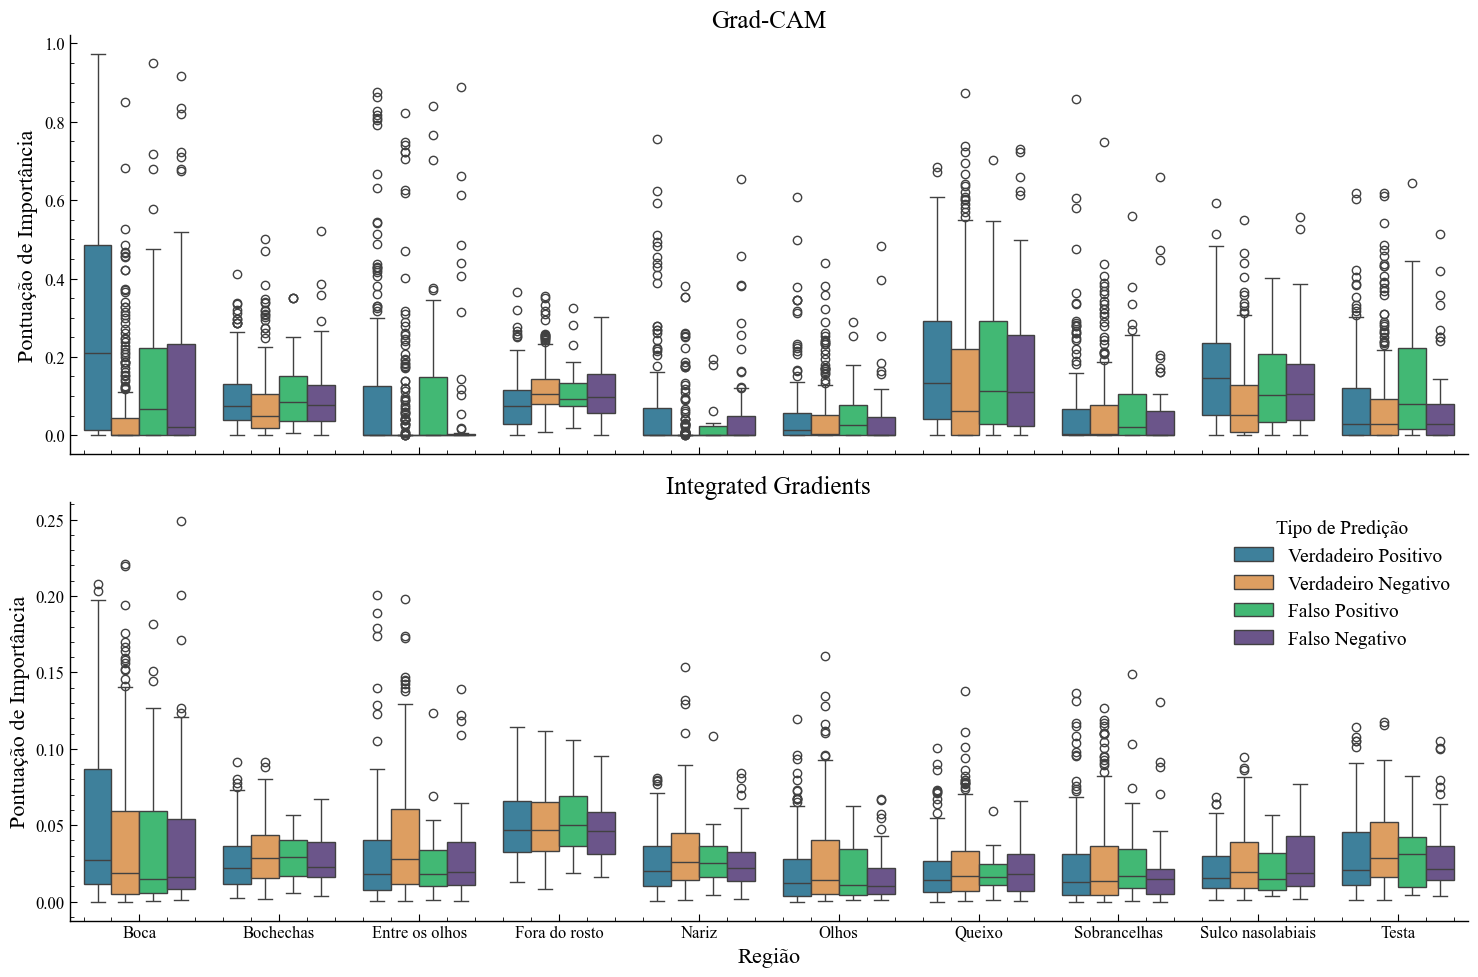

In [46]:
import numpy as np

# Step 1: Translate region names if needed
xai_df['Região'] = xai_df['Region'].map(region_translation)

# Step 2: Order regions by overall median score
region_order_pt = (["Boca",	"Bochechas",	"Entre os olhos",	"Fora do rosto"	,"Nariz",	"Olhos"	,"Queixo"	,"Sobrancelhas"	,"Sulco nasolabiais",	"Testa"])

# Step 3: Create subplots
fig, axes = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

for ax, method in zip(axes, ['GC', 'IG']):
    subset = xai_df[xai_df['XAI_Method'] == method]

    # Plot boxplot
    sns.boxplot(
        data=subset,
        x='Região',
        y='Score',
        hue='Grupo',
        order=region_order_pt,
        ax=ax,
    )

    # Compute per-group ranks
    #medians_dor = (
    #    subset[subset['Grupo'] == 'Dor']
    #    .groupby('Região')['Score']
    #    .mean()
    #    .sort_values(ascending=False)
    #    .rank(ascending=False, method='min')
    #    .astype(int)
    #    .to_dict()
    #)
    #medians_sem_dor = (
    #    subset[subset['Grupo'] == 'Sem Dor']
    #    .groupby('Região')['Score']
    #    .mean()
    #    .sort_values(ascending=False)
    #    .rank(ascending=False, method='min')
    #    .astype(int)
    #    .to_dict()
    #)

    # Add annotation for each box (offset each group slightly)
    for i, region in enumerate(region_order_pt):
        y_max_dor = subset[(subset['Região'] == region) & (subset['Grupo'] == 'Dor')]['Score'].median()
        y_max_sem_dor = subset[(subset['Região'] == region) & (subset['Grupo'] == 'Sem Dor')]['Score'].median()


        # Dor (left)
       # if region in medians_dor:
       #     rank = medians_dor[region]
       #     color = '#2ECC71' if rank <= 3 else 'lightgray'
       #     ax.text(
       #         i - 0.2, y_max_dor, f"{rank}",
       #         ha='center', va='bottom',
       #         fontsize=9, fontweight='bold', color='black',
       #         bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2')
       #     )

        # Sem Dor (right)
       # if region in medians_sem_dor:
       #     rank = medians_sem_dor[region]
       #     color = '#2ECC71' if rank <= 3 else 'lightgray'
       #     ax.text(
       #         i + 0.2, y_max_sem_dor, f"{rank}",
       #         ha='center', va='bottom',
       #         fontsize=9, fontweight='bold', color='black',
       #         bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2')
       #     )

    ax.set_title('Grad-CAM' if method == 'GC' else 'Integrated Gradients')
    ax.set_ylabel('Pontuação de Importância')
    ax.tick_params(axis='x', rotation=0)

    if method == 'IG':
        ax.legend(title='Tipo de Predição', loc='upper right')
    else:
        ax.legend_.remove()

# Final layout
plt.tight_layout()
plt.savefig(os.path.join(path_xai, 'xai_distribution_ranked.pdf'), dpi=300, bbox_inches='tight', pad_inches=0)


In [47]:

# Translate region names
xai_df['Região'] = xai_df['Region'].map(region_translation)

# Group by Region, Group, and XAI_Method → mean and std
summary = (
    xai_df
    .groupby(['Group', 'XAI_Method', 'Região'])['Score']
    .agg(['mean', 'std'])
    .reset_index()
)

summary['ScoreFormatted'] = summary.apply(
    lambda row: f"{row['mean']:.4f} ± {row['std']:.4f}".replace(".", ","), axis=1
)

# Pivot: rows = Group + XAI_Method, columns = Região
table = summary.pivot_table(
    index=['XAI_Method', 'Group'],
    columns='Região',
    values='ScoreFormatted',
    aggfunc='first'
).reset_index()




# Optional: order columns for presentation
cols = ['Group', 'XAI_Method'] + sorted([col for col in table.columns if col not in ['Group', 'XAI_Method']])
table = table[cols]

# Display
table


Região,Group,XAI_Method,Boca,Bochechas,Entre os olhos,Fora do rosto,Nariz,Olhos,Queixo,Sobrancelhas,Sulco nasolabiais,Testa
0,FN,GC,"0,1790 ± 0,2680","0,1031 ± 0,0998","0,0737 ± 0,1888","0,1104 ± 0,0671","0,0634 ± 0,1332","0,0457 ± 0,0931","0,1833 ± 0,2053","0,0575 ± 0,1247","0,1357 ± 0,1294","0,0730 ± 0,1150"
1,FP,GC,"0,1744 ± 0,2473","0,1140 ± 0,1001","0,1249 ± 0,2390","0,1118 ± 0,0673","0,0201 ± 0,0462","0,0593 ± 0,0798","0,1752 ± 0,1799","0,0902 ± 0,1389","0,1329 ± 0,1115","0,1471 ± 0,1593"
2,TN,GC,"0,0601 ± 0,1286","0,0789 ± 0,0886","0,0490 ± 0,1410","0,1169 ± 0,0605","0,0183 ± 0,0596","0,0421 ± 0,0741","0,1411 ± 0,1849","0,0569 ± 0,1013","0,0894 ± 0,1033","0,0788 ± 0,1202"
3,TP,GC,"0,2772 ± 0,2746","0,0976 ± 0,0843","0,1067 ± 0,2060","0,0831 ± 0,0681","0,0663 ± 0,1329","0,0489 ± 0,0915","0,1785 ± 0,1640","0,0615 ± 0,1195","0,1631 ± 0,1328","0,0877 ± 0,1195"
4,FN,IG,"0,0422 ± 0,0535","0,0285 ± 0,0167","0,0293 ± 0,0303","0,0461 ± 0,0175","0,0270 ± 0,0192","0,0164 ± 0,0168","0,0205 ± 0,0158","0,0201 ± 0,0241","0,0263 ± 0,0197","0,0309 ± 0,0246"
5,FP,IG,"0,0400 ± 0,0498","0,0289 ± 0,0152","0,0247 ± 0,0247","0,0547 ± 0,0225","0,0280 ± 0,0195","0,0180 ± 0,0169","0,0186 ± 0,0122","0,0274 ± 0,0328","0,0214 ± 0,0168","0,0306 ± 0,0206"
6,TN,IG,"0,0397 ± 0,0478","0,0320 ± 0,0197","0,0422 ± 0,0395","0,0496 ± 0,0205","0,0326 ± 0,0250","0,0267 ± 0,0293","0,0242 ± 0,0236","0,0256 ± 0,0291","0,0265 ± 0,0212","0,0352 ± 0,0238"
7,TP,IG,"0,0543 ± 0,0565","0,0259 ± 0,0180","0,0300 ± 0,0350","0,0498 ± 0,0209","0,0253 ± 0,0189","0,0204 ± 0,0226","0,0197 ± 0,0184","0,0237 ± 0,0278","0,0208 ± 0,0152","0,0302 ± 0,0247"


In [48]:
# Step 1: Calculate mean score per group-method-region
grouped = (
    xai_df
    .groupby(['Group', 'XAI_Method', 'Região'])['Score']
    .mean()
    .reset_index()
)

# Step 2: Rank and filter top-3 per group-method
grouped['Rank'] = grouped.groupby(['Group', 'XAI_Method'])['Score'].rank(ascending=False, method='first')
top3 = grouped[grouped['Rank'] <= 10].copy()

# Step 3: Sort properly for display
top3 = top3.sort_values(['XAI_Method','Group', 'Rank'])

# Step 4: Pivot to a nice table format
top3['Rank'] = top3['Rank'].astype(int)
top3_formatted = top3.pivot_table(
    index=['XAI_Method', 'Group'],
    columns='Rank',
    values='Região',
    aggfunc='first'
).reset_index()

# Optional: Rename columns
top3_formatted.columns.name = None
top3_formatted.rename(columns={1: 'Top 1', 2: 'Top 2', 3: 'Top 3', 4: 'Top 4', 5: 'Top 5', 6: 'Top 6', 7: 'Top 7', 8: 'Top 8', 9: 'Top 9', 10: 'Top 10'}, inplace=True)

top3_formatted

,XAI_Method,Group,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10
0,GC,FN,Queixo,Boca,Sulco nasolabiais,Fora do rosto,Bochechas,Entre os olhos,Testa,Nariz,Sobrancelhas,Olhos
1,GC,FP,Queixo,Boca,Testa,Sulco nasolabiais,Entre os olhos,Bochechas,Fora do rosto,Sobrancelhas,Olhos,Nariz
2,GC,TN,Queixo,Fora do rosto,Sulco nasolabiais,Bochechas,Testa,Boca,Sobrancelhas,Entre os olhos,Olhos,Nariz
3,GC,TP,Boca,Queixo,Sulco nasolabiais,Entre os olhos,Bochechas,Testa,Fora do rosto,Nariz,Sobrancelhas,Olhos
4,IG,FN,Fora do rosto,Boca,Testa,Entre os olhos,Bochechas,Nariz,Sulco nasolabiais,Queixo,Sobrancelhas,Olhos
5,IG,FP,Fora do rosto,Boca,Testa,Bochechas,Nariz,Sobrancelhas,Entre os olhos,Sulco nasolabiais,Queixo,Olhos
6,IG,TN,Fora do rosto,Entre os olhos,Boca,Testa,Nariz,Bochechas,Olhos,Sulco nasolabiais,Sobrancelhas,Queixo
7,IG,TP,Boca,Fora do rosto,Testa,Entre os olhos,Bochechas,Nariz,Sobrancelhas,Sulco nasolabiais,Olhos,Queixo


## Agreement

In [49]:
from scipy.stats import spearmanr

def calculate_region_rank_correlation(importance_dict1, importance_dict2):
    """
    Calculates Spearman's rank correlation coefficient between two dictionaries of importance scores by region.

    Args:
    importance_dict1 (dict): Dictionary of region importance scores from the first method.
    importance_dict2 (dict): Dictionary of region importance scores from the second method.

    Returns:
    float: Spearman's rank correlation coefficient between -1 and 1.
    """
    # Get the regions common to both importance dictionaries
    common_regions = set(importance_dict1.keys()).intersection(importance_dict2.keys())

    # Extract the importance scores for these common regions in the same order for both dictionaries
    scores1 = [importance_dict1[region] for region in common_regions]
    scores2 = [importance_dict2[region] for region in common_regions]

    # Calculate Spearman's rank correlation coefficient
    correlation, _ = spearmanr(scores1, scores2)

    return correlation


In [50]:
def calculate_region_rank_agreement(importance_dict1, importance_dict2, k, return_agreed_set=False):
    """
    Calculates the rank-based agreement between two dictionaries of importance scores by region.

    Args:
    importance_dict1 (dict): Dictionary of region importance scores from the first method.
    importance_dict2 (dict): Dictionary of region importance scores from the second method.
    k (int): Number of top regions to consider.
    return_agreed_set (bool): Whether to return the set of agreed regions in matching ranks.

    Returns:
    float: Agreement score between 0 and 1, representing the fraction of matching top-k regions by rank.
    list (optional): List of agreed regions in matching ranks if return_agreed_set is True.
    """
    # Sort each dictionary by importance and get the ordered top k regions as lists
    top_k_regions_1 = sorted(importance_dict1, key=importance_dict1.get, reverse=True)[:k]
    top_k_regions_2 = sorted(importance_dict2, key=importance_dict2.get, reverse=True)[:k]

    # Calculate matching regions in the same rank positions
    agreed_regions = [region1 for region1, region2 in zip(top_k_regions_1, top_k_regions_2) if region1 == region2]

    # Calculate the agreement score based on matching positions
    agreement_score = len(agreed_regions) / k

    if return_agreed_set:
        return agreement_score, agreed_regions
    else:
        return agreement_score

In [51]:
def calculate_region_agreement(importance_dict1, importance_dict2, k, return_agreed_set=False):
    """
    Calculates the agreement between two dictionaries of importance scores by region.

    Args:
    importance_dict1 (dict): Dictionary of region importance scores from the first method.
    importance_dict2 (dict): Dictionary of region importance scores from the second method.
    k (int): Number of top regions to consider.
    return_agreed_set (bool): Whether to return the set of agreed regions in the result.

    Returns:
    float: Agreement score between 0 and 1, representing the fraction of shared top-k regions.
    set (optional): Set of agreed regions if return_agreed_set is True.
    """
    # Sort each dictionary by importance and get the top k regions
    top_k_regions_1 = set(sorted(importance_dict1, key=importance_dict1.get, reverse=True)[:k])
    top_k_regions_2 = set(sorted(importance_dict2, key=importance_dict2.get, reverse=True)[:k])

    # Calculate the intersection of the top k regions
    agreed_regions = top_k_regions_1.intersection(top_k_regions_2)

    # Calculate the agreement score
    agreement_score = len(agreed_regions) / k

    if return_agreed_set:
        return agreement_score, agreed_regions
    else:
        return agreement_score


In [52]:
# Traduções dos grupos
group_translation = {
    'TP': 'Verdadeiro Positivo',
    'TN': 'Verdadeiro Negativo',
    'FP': 'Falso Positivo',
    'FN': 'Falso Negativo'
}

In [53]:
from itertools import combinations
import pandas as pd

pd.options.display.float_format = lambda x: f"{x:,.4f}".replace(",", "X").replace(".", ",").replace("X", ".")


# Step 1: Create all group-method combinations
all_scores = {}

for method in ['GC', 'IG']:
    for group in ['Verdadeiro Positivo', "Verdadeiro Negativo", "Falso Positivo", "Falso Negativo"]:
        subset = xai_df[(xai_df['Grupo'] == group) & (xai_df['XAI_Method'] == method)]
        region_scores = (
            subset[['Região', 'Score']]
            .groupby('Região')
            .mean()
            .reset_index()
            .set_index('Região')['Score']
            .to_dict()
        )
        # Sort descending by score
        region_scores = dict(sorted(region_scores.items(), key=lambda x: x[1], reverse=True))

        all_scores[f"{group}_{method}"] = region_scores

results = []

for (name1, dict1), (name2, dict2) in combinations(all_scores.items(), 2):
    rank_corr = calculate_region_rank_correlation(dict1, dict2)

    rank_agreement_score, rank_agreed_set = calculate_region_rank_agreement(dict1, dict2, k=3, return_agreed_set=True)
    agreement_score, agreed_set = calculate_region_agreement(dict1, dict2, k=3, return_agreed_set=True)

    row = {
        'Model_1': name1,
        'Model_2': name2,
        'RankCorrelation': rank_corr,
        'RankAgreement@3': rank_agreement_score,
        'Agreement@3': agreement_score,
        'RankAgreedRegions@3': ', '.join(sorted(rank_agreed_set)),
        'AgreedRegions@3': ', '.join(sorted(agreed_set))
    }
    results.append(row)

comparison_df = pd.DataFrame(results)
comparison_df



,Model_1,Model_2,RankCorrelation,RankAgreement@3,Agreement@3,RankAgreedRegions@3,AgreedRegions@3
0,Verdadeiro Positivo_GC,Verdadeiro Negativo_GC,"0,5273","0,3333","0,6667",Sulco nasolabiais,"Queixo, Sulco nasolabiais"
1,Verdadeiro Positivo_GC,Falso Positivo_GC,"0,8788","0,0000","0,6667",,"Boca, Queixo"
2,Verdadeiro Positivo_GC,Falso Negativo_GC,"0,9030","0,3333","1,0000",Sulco nasolabiais,"Boca, Queixo, Sulco nasolabiais"
3,Verdadeiro Positivo_GC,Verdadeiro Positivo_IG,"0,2000","0,3333","0,3333",Boca,Boca
4,Verdadeiro Positivo_GC,Verdadeiro Negativo_IG,"0,0545","0,0000","0,3333",,Boca
5,Verdadeiro Positivo_GC,Falso Positivo_IG,"0,1030","0,0000","0,3333",,Boca
6,Verdadeiro Positivo_GC,Falso Negativo_IG,"0,3818","0,0000","0,3333",,Boca
7,Verdadeiro Negativo_GC,Falso Positivo_GC,"0,6364","0,3333","0,3333",Queixo,Queixo
8,Verdadeiro Negativo_GC,Falso Negativo_GC,"0,7697","0,6667","0,6667","Queixo, Sulco nasolabiais","Queixo, Sulco nasolabiais"
9,Verdadeiro Negativo_GC,Verdadeiro Positivo_IG,"-0,0182","0,3333","0,3333",Fora do rosto,Fora do rosto


In [37]:
comparison_df["XAI_Comparison"] = (
    comparison_df["Model_1"].str.strip().str.extract(r'_(GC|IG)$')[0] + " x " +
    comparison_df["Model_2"].str.strip().str.extract(r'_(GC|IG)$')[0]
)


In [38]:
comparison_df[comparison_df["XAI_Comparison"] == "GC x GC"]

,Model_1,Model_2,RankCorrelation,RankAgreement@3,Agreement@3,RankAgreedRegions@3,AgreedRegions@3,XAI_Comparison
0,Verdadeiro Positivo_GC,Verdadeiro Negativo_GC,"0,0545","0,0000","0,3333",,Olhos,GC x GC
1,Verdadeiro Positivo_GC,Falso Positivo_GC,"0,9273","1,0000","1,0000","Boca, Nariz, Olhos","Boca, Nariz, Olhos",GC x GC
2,Verdadeiro Positivo_GC,Falso Negativo_GC,"0,3939","0,0000","0,6667",,"Boca, Olhos",GC x GC
7,Verdadeiro Negativo_GC,Falso Positivo_GC,"0,2485","0,0000","0,3333",,Olhos,GC x GC
8,Verdadeiro Negativo_GC,Falso Negativo_GC,"0,7697","0,3333","0,3333",Olhos,Olhos,GC x GC
13,Falso Positivo_GC,Falso Negativo_GC,"0,5758","0,0000","0,6667",,"Boca, Olhos",GC x GC


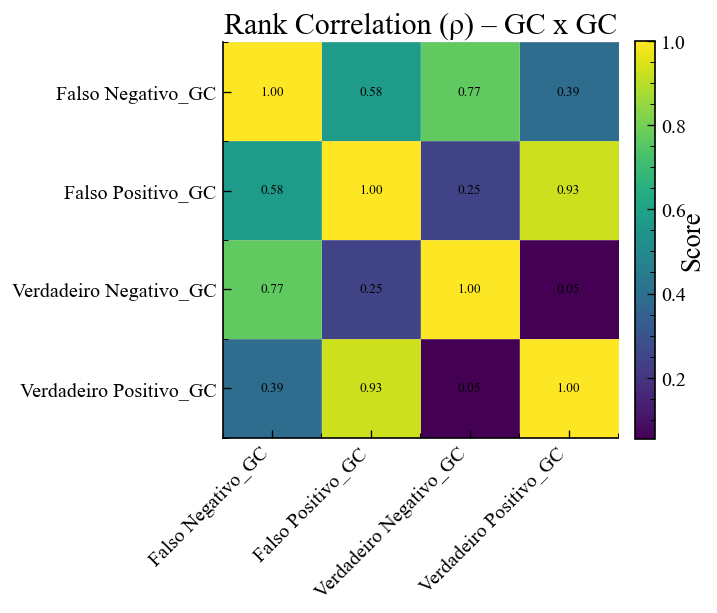

Saved: heatmaps/GC_x_GC_RankCorrelation.png


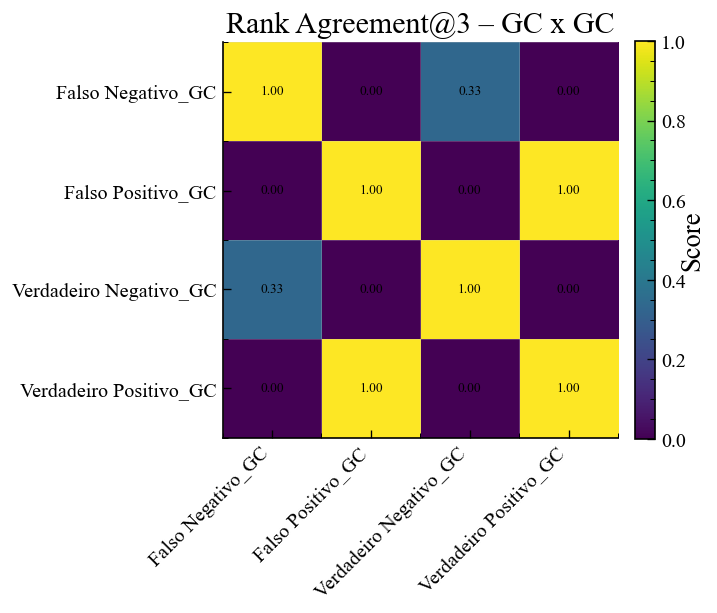

Saved: heatmaps/GC_x_GC_RankAgreement@3.png


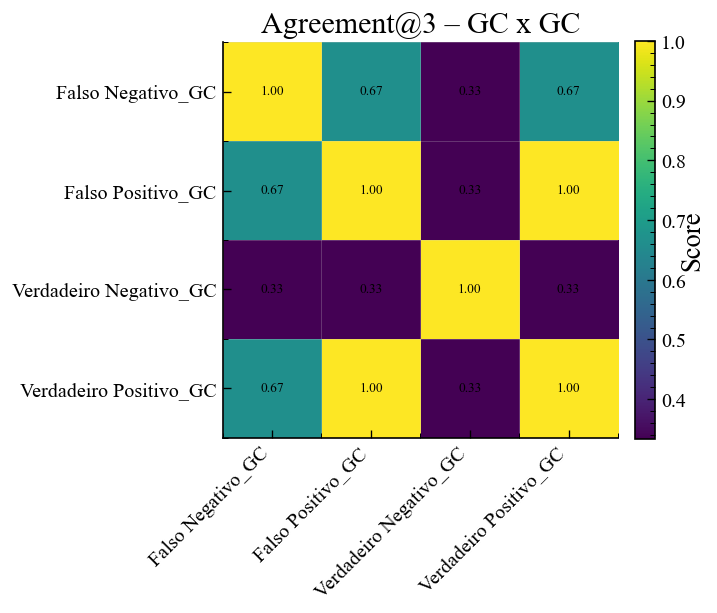

Saved: heatmaps/GC_x_GC_Agreement@3.png


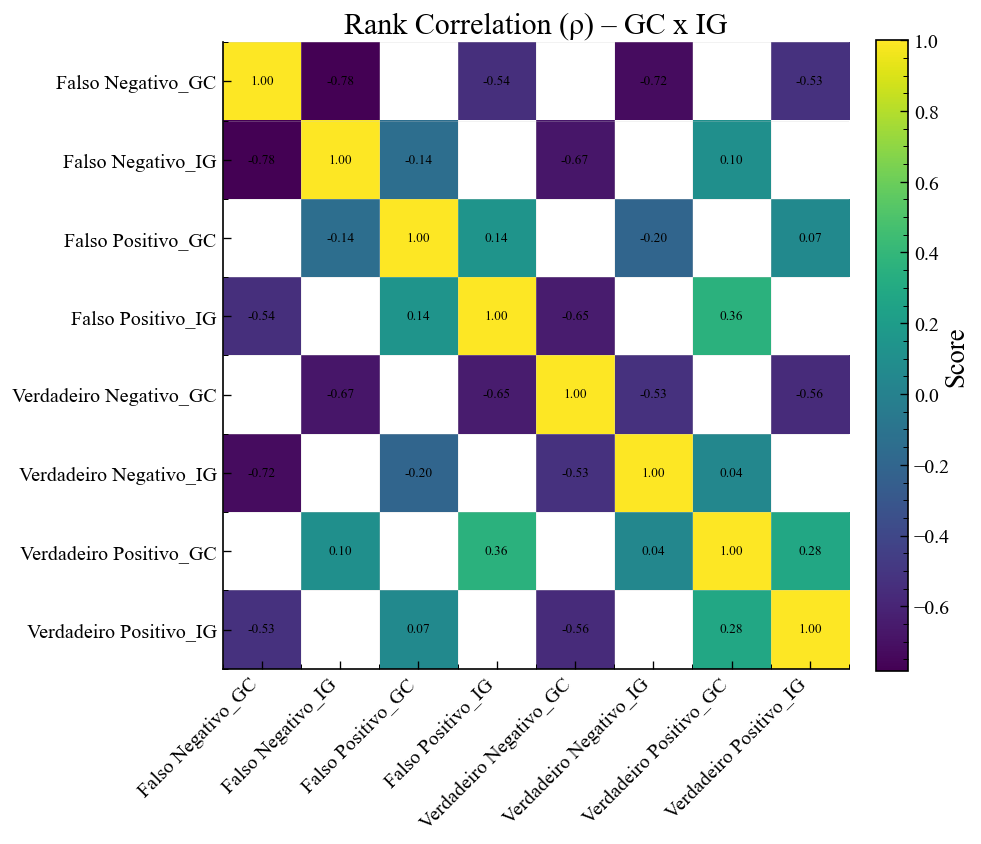

Saved: heatmaps/GC_x_IG_RankCorrelation.png


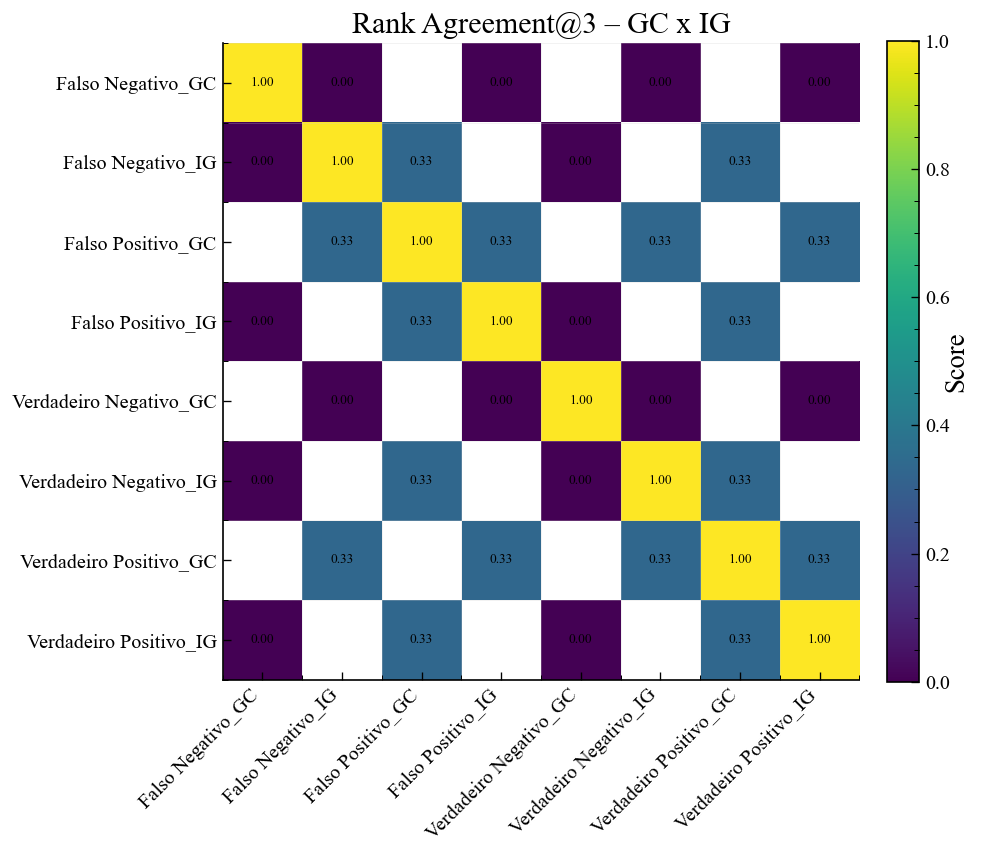

Saved: heatmaps/GC_x_IG_RankAgreement@3.png


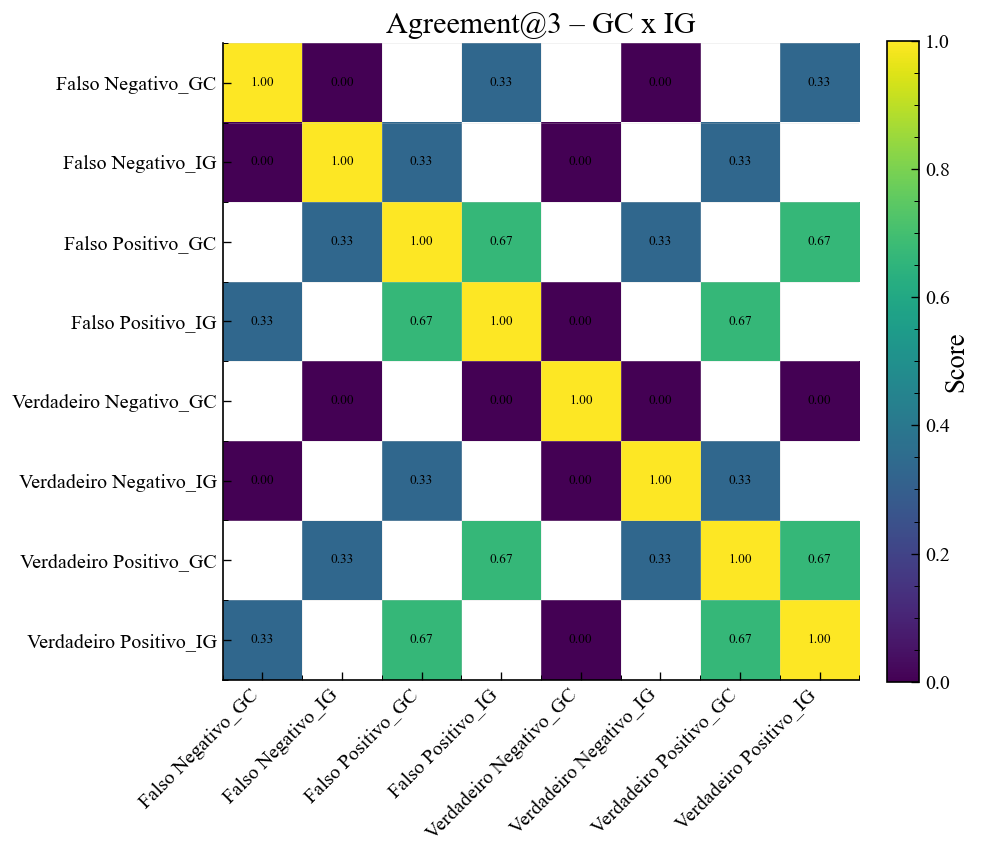

Saved: heatmaps/GC_x_IG_Agreement@3.png


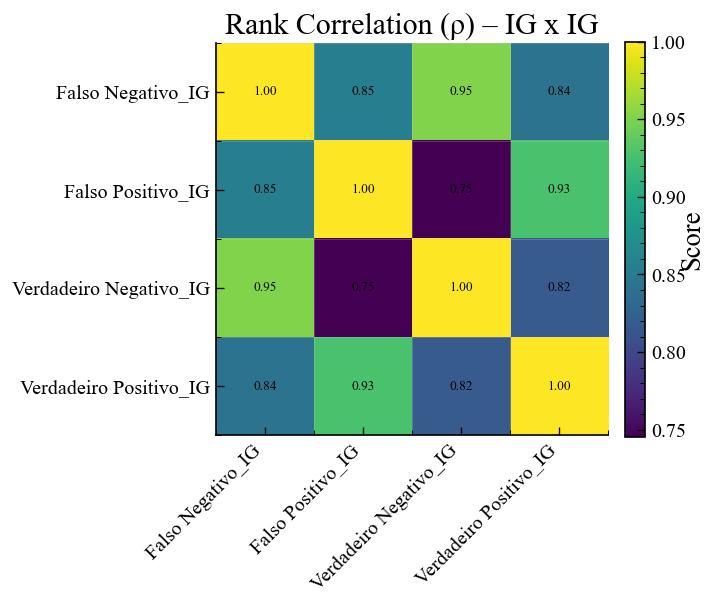

Saved: heatmaps/IG_x_IG_RankCorrelation.png


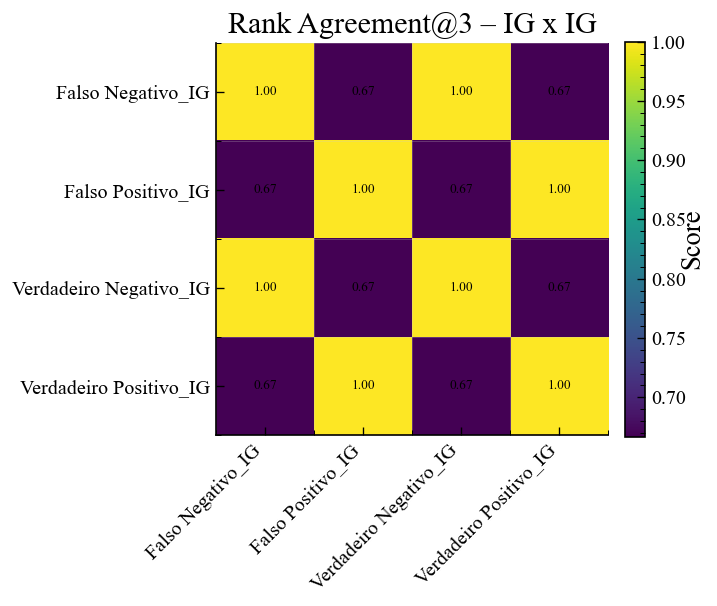

Saved: heatmaps/IG_x_IG_RankAgreement@3.png


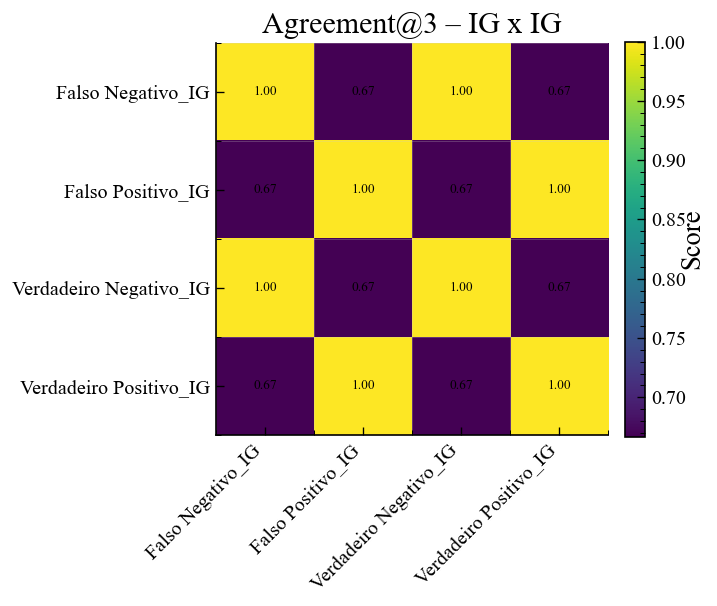

Saved: heatmaps/IG_x_IG_Agreement@3.png


In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- util: construir matriz simétrica a partir de pares (Model_1, Model_2) ---
def build_matrix(df, metric: str):
    labels = sorted(set(df["Model_1"]).union(set(df["Model_2"])))
    idx = {lab: i for i, lab in enumerate(labels)}
    n = len(labels)
    mat = np.full((n, n), np.nan, dtype=float)

    for _, row in df.iterrows():
        i, j = idx[row["Model_1"]], idx[row["Model_2"]]
        val = float(str(row[metric]).replace(",", "."))  # handle numbers with comma
        mat[i, j] = val
        mat[j, i] = val

    np.fill_diagonal(mat, 1.0)
    return mat, labels

def plot_heatmap(matrix, labels, title, outfile):
    fig, ax = plt.subplots(figsize=(0.55*len(labels)+4, 0.55*len(labels)+4), dpi=120)
    im = ax.imshow(matrix, interpolation="nearest")

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)

    ax.set_xticks(np.arange(-.5, len(labels), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(labels), 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.5, alpha=0.3)

    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Score", rotation=90, va="center")

    # annotate
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            v = matrix[i, j]
            ax.text(j, i, "" if np.isnan(v) else f"{v:.2f}",
                    ha="center", va="center", fontsize=8)

    fig.tight_layout()
    os.makedirs("heatmaps", exist_ok=True)
    fig.savefig(outfile, bbox_inches="tight")
    plt.show()
    print(f"Saved: {outfile}")

# --- metrics to plot ---
metrics = [
    ("RankCorrelation", "Rank Correlation (ρ)"),
    ("RankAgreement@3", "Rank Agreement@3"),
    ("Agreement@3",     "Agreement@3"),
]

# --- loop over each slice of XAI_Comparison ---
for method_pair, slice_df in comparison_df.groupby("XAI_Comparison"):
    for metric, title in metrics:
        mat, labs = build_matrix(slice_df, metric)
        fname = f"heatmaps/{method_pair.replace(' ', '_')}_{metric}.png"
        plot_heatmap(mat, labs, f"{title} – {method_pair}", fname)


## Vizu

In [ ]:
faces = []
for i in os.listdir(path_mesh):
    with open(os.path.join(path_mesh,f'{i}'), 'rb') as f:
        face_mesh = np.array(pickle.load(f))

    faces.append(face_mesh)

faces_np = np.array(faces)
face_mesh_mean = faces_np.mean(axis=0)

In [ ]:
avg = merge_symmetric_masks(create_face_regions_masks(face_mesh_mean))

In [ ]:
test = xai_df[xai_df['Group'] == 'TP']

In [ ]:
test

In [ ]:
test = test[['Region', 'Score']].groupby('Region').mean().reset_index()
test['Região'] = test['Region'].map(region_translation)

In [ ]:
test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw_face_colormap(region_scores, region_masks, title='', cmap='coolwarm', show_top_n=3):
    h, w = next(iter(region_masks.values())).shape
    heatmap = np.zeros((h, w), dtype=np.float32)

    values = region_scores['Score'].values
    min_val, max_val = values.min(), values.max()

    for region, mask in region_masks.items():
        score = region_scores[region_scores['Region'] == region]['Score'].values[0]
        normalized_score = (score - min_val) / (max_val - min_val + 1e-8)
        heatmap = np.maximum(heatmap, mask * normalized_score)

    # Get top-N regions by original (non-normalized) score
    top_features = (
        region_scores.sort_values(by='Score', ascending=False)
        .head(show_top_n)
        .apply(lambda row: f"{row['Região']}", axis=1)
        .tolist()
    )
    top_text = f"Top regiões {show_top_n}: " + "/".join(top_features)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 7))  # Taller to leave space below
    im = ax.imshow(heatmap, cmap=cmap)
    ax.set_title(title)
    ax.axis('off')

    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, label='Importância (XAI)')

    # Add top features below figure
    fig.text(0.26, 0.15, top_text, ha='center', fontsize=15)

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for bottom text
    plt.show()


In [ ]:
draw_face_colormap(test, avg)

# Image and XAI alignment

In [2]:
def to_uint8(m): return (np.clip(m, 0, 1)*255).round().astype(np.uint8)

Calculate mean landmarks of already detected face mesh

In [3]:
path_mesh = 'Datasets\\DatasetFaces\\Landmarks'

model = 'VGGFace'
#path_xai = f'experiments\\{model}\\xai_masks'
#path_mean_XAI = f'experiments\\{model}\\xai_masks\\mean_masks'
#path_results = f'experiments\\{model}\\ensemble_10_results.pkl'


path_xai = f'experiments\\{model}\\xai_masks_MCDP'
path_mean_XAI = f'experiments\\{model}\\xai_masks_MCDP\\mean_masks'
path_results = f'experiments\\{model}\\results_MCDP_50_0.5.pkl'

with open(path_results, 'rb') as f:
    daata = pickle.load(f)
    daata.pop('embeddings', None)  # Remove embeddings if present
    dataframe = pd.DataFrame(daata)

In [4]:
faces = []
for i in os.listdir(path_mesh):
    with open(os.path.join(path_mesh,f'{i}'), 'rb') as f:
        face_mesh = np.array(pickle.load(f))

    faces.append(face_mesh)

faces_np = np.array(faces)
face_mesh_mean = faces_np.mean(axis=0)

In [5]:
landmarks_mean = np.array([face_mesh_mean[86], 
                           face_mesh_mean[52],
                           face_mesh_mean[61],
                           face_mesh_mean[88],
                           face_mesh_mean[38]])

## Group by TP, TN, FP, FN

Alterar para usar std no MCDP

In [6]:

for tipo, condition in {
    'TP': (dataframe['labels'] == 1) & (dataframe['preds'] == 1),
    'TN': (dataframe['labels'] == 0) & (dataframe['preds'] == 0),
    'FP': (dataframe['labels'] == 0) & (dataframe['preds'] == 1),
    'FN': (dataframe['labels'] == 1) & (dataframe['preds'] == 0)
}.items():
    
    stack_img = []
    stack_GC = []
    stack_IG = []

    new_df = dataframe[condition]

    warped_imgs = []
    warped_xai_GC = []
    warped_xai_IG = []

    for _, row in new_df.iterrows():
        img_path = row['img_names']

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        gc_id = img_path.split('\\')[-1].replace('.jpg', f'_GC.npz')
        ig_id = gc_id.replace('GC', 'IG')

        
        mask_GC  = np.load(os.path.join(path_xai, gc_id))['mask'] / 255
        mask_IG  = np.load(os.path.join(path_xai, ig_id))['mask'] / 255
            
        mask_GC = cv2.resize(mask_GC, (512,512))
        mask_IG = cv2.resize(mask_IG, (512,512))
                    
        mesh_id = gc_id.replace(f'_GC.npz', '.pkl')
        with open(os.path.join(path_mesh, mesh_id), 'rb') as f:
            face_mesh = np.array(pickle.load(f))
        
        if face_mesh is not None:
            
            landmarks =  np.array([face_mesh[86], 
                                    face_mesh[52],
                                    face_mesh[61],
                                    face_mesh[88],
                                    face_mesh[38]])
    
            # first align image
            transform_rigid = AffineTransform()
            transform_rigid.estimate(src=landmarks_mean, dst=landmarks)
            result = warp(img, transform_rigid) * 255
            result_mask_GC = warp(mask_GC, transform_rigid)*255
            result_mask_IG = warp(mask_IG, transform_rigid)*255

            warped_imgs.append(result.astype(np.uint8))
            warped_xai_GC.append(result_mask_GC.astype(np.uint8))
            warped_xai_IG.append(result_mask_IG.astype(np.uint8))
                                
    mean_img = np.mean(np.array(warped_imgs), axis=0)/255

    # Compute standard deviation and normalize it
    #std_img = np.std(np.array(warped_imgs), axis=0) / 255
    #std_img_norm = (std_img - std_img.min()) / (std_img.max() - std_img.min() + 1e-8)  # avoid division by 0

    # Create red heatmap where R = std, G=B=0
    #red_heatmap = np.zeros_like(mean_img)
    #red_heatmap[..., 0] = std_img_norm[..., 0]  # only red channel

    # Blend mean image with red std map
    #overlay = (mean_img * 0.7 + red_heatmap * 0.3)

    mean_xai_GC = np.mean(np.array(warped_xai_GC), axis=0)
    mean_xai_IG = np.mean(np.array(warped_xai_IG), axis=0)

    result_cam_GC, alpha_channel_cam_GC = attribution_mask_processing(mean_xai_GC)
    result_cam_IG, alpha_channel_cam_IG = attribution_mask_processing(mean_xai_IG)

    test_gc = np.expand_dims(((result_cam_GC * alpha_channel_cam_GC) > 0).astype('int'),-1)
    test_ig = np.expand_dims(((result_cam_IG * alpha_channel_cam_IG) > 0).astype('int'),-1)

    # Define the plot colors
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

    # Plot and save
    plt.figure(figsize=(10, 10))
    plt.imshow(mean_img)
    plt.axis('off')
    plt.tight_layout()
    save_name = tipo + '.png'
    save_path = os.path.join(path_mean_XAI, save_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

    plt.figure(figsize=(10,10))
    plt.imshow(mean_img)
    plt.imshow(result_cam_GC, cmap=cmap, alpha=alpha_channel_cam_GC)
    plt.axis('off')
    plt.tight_layout()
    save_name = tipo + '_GC' + '.png'
    save_path = os.path.join(path_mean_XAI, save_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight',pad_inches=0)
    plt.close()


    plt.figure(figsize=(10,10))
    plt.imshow(mean_img)
    plt.imshow(result_cam_IG, cmap=cmap, alpha=alpha_channel_cam_IG)
    plt.axis('off')
    plt.tight_layout()
    save_name = tipo + '_IG' + '.png'
    save_path = os.path.join(path_mean_XAI, save_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight',pad_inches=0)
    plt.close()

  File "c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\leona\anaconda3\envs\doutorado\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\leona\anaconda3\envs\doutorado\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\leona\anaconda3\envs\doutorado\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


In [7]:
import os
import cv2
import numpy as np

classes = ['TP', 'TN', 'FP', 'FN']
rows = ['', f'_GC', f'_IG']  # row suffixes

# Load, resize, and prepare
images = []
for suffix in rows:
    row_imgs = []
    for c in classes:
        fname = f"{c}{suffix}.png"
        fpath = os.path.join(path_mean_XAI, fname)
        img = cv2.imread(fpath)
        if img is None:
            raise FileNotFoundError(f"Could not load {fpath}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)  # resize
        row_imgs.append(img)
    row_stack = np.hstack(row_imgs)   # stack row horizontally
    images.append(row_stack)

# Stack rows vertically
final_img = np.vstack(images)

# Save final panel
save_path = os.path.join(path_mean_XAI, f"merged_panel.png")
cv2.imwrite(save_path, cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR))
print(f"Saved: {save_path}")


Saved: experiments\VGGFace\xai_masks_MCDP\mean_masks\merged_panel.png


## Group by Pred

In [ ]:
stack_img = []
stack_GC = []
stack_IG = []
name = 'Pain'

for tipo in ['Pain', 'No Pain']:

    if tipo == 'No Pain':
        name = 'No Pain'
        stack_img = []
        stack_GC = []
        stack_IG = []

    if tipo == 'Pain':
        new_df = dataframe[(dataframe['preds'] == 1)]
    elif tipo == 'No Pain':
        new_df = dataframe[(dataframe['preds'] == 0)]

    scores = []


    warped_imgs = []
    warped_xai_GC = []
    warped_xai_IG = []

    for _, row in new_df.iterrows():
        img_path = row['img_names']

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        gc_id = img_path.split('\\')[-1].replace('.jpg', '_GC.pkl')
        ig_id = gc_id.replace('GC', 'IG')

        with open(os.path.join(path_xai, gc_id), 'rb') as f:
            mask_GC  = pickle.load(f)

        with open(os.path.join(path_xai, ig_id), 'rb') as f:
            mask_IG  = pickle.load(f)

        mask_GC = cv2.resize(mask_GC, (512,512))
        mask_IG = cv2.resize(mask_IG, (512,512))
                    
        mesh_id = gc_id.replace('_GC.pkl', '.pkl')
        with open(os.path.join(path_mesh, mesh_id), 'rb') as f:
            face_mesh = np.array(pickle.load(f))
        
        if face_mesh is not None:
            
            landmarks =  np.array([face_mesh[86], 
                                    face_mesh[52],
                                    face_mesh[61],
                                    face_mesh[88],
                                    face_mesh[38]])
    
            # first align image
            transform_rigid = AffineTransform()
            transform_rigid.estimate(src=landmarks_mean, dst=landmarks)
            result = warp(img, transform_rigid) * 255
            result_mask_GC = warp(mask_GC, transform_rigid)*255
            result_mask_IG = warp(mask_IG, transform_rigid)*255

            warped_imgs.append(result.astype(np.uint8))
            warped_xai_GC.append(result_mask_GC.astype(np.uint8))
            warped_xai_IG.append(result_mask_IG.astype(np.uint8))
                                
    mean_img = np.mean(np.array(warped_imgs), axis=0)/255
    mean_xai_GC = np.mean(np.array(warped_xai_GC), axis=0)
    mean_xai_IG = np.mean(np.array(warped_xai_IG), axis=0)

    result_cam_GC, alpha_channel_cam_GC = attribution_mask_processing(mean_xai_GC)
    result_cam_IG, alpha_channel_cam_IG = attribution_mask_processing(mean_xai_IG)

    save_name = "MEAN_GC_" + tipo + '.pkl'
    save_path = os.path.join(path_mean_XAI, save_name)
    with open(save_path, 'wb') as f:
        pickle.dump(result_cam_GC, f)

    save_name = "MEAN_IG_" + tipo + '.pkl'
    save_path = os.path.join(path_mean_XAI, save_name)
    with open(save_path, 'wb') as f:
        pickle.dump(result_cam_IG, f)

    test_gc = np.expand_dims(((result_cam_GC * alpha_channel_cam_GC) > 0).astype('int'),-1)
    test_ig = np.expand_dims(((result_cam_IG * alpha_channel_cam_IG) > 0).astype('int'),-1)

    # Define the plot colors
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

    plt.figure(figsize=(10,10))
    plt.imshow(mean_img)
    plt.imshow(result_cam_GC, cmap=cmap, alpha=alpha_channel_cam_GC)
    plt.axis('off')
    plt.tight_layout()
    save_name = tipo + '_GC' + '.png'
    save_path = os.path.join(path_mean_XAI, save_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight',pad_inches=0)
    plt.close()


    plt.figure(figsize=(10,10))
    plt.imshow(mean_img)
    plt.imshow(result_cam_IG, cmap=cmap, alpha=alpha_channel_cam_IG)
    plt.axis('off')
    plt.tight_layout()
    save_name = tipo + '_IG' + '.png'
    save_path = os.path.join(path_mean_XAI, save_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight',pad_inches=0)
    plt.close()

## Group By Prob

In [21]:
step = 0.1 # Step for probabilities range

stack_img = []
stack_GC = []
stack_IG = []
name = 'TP_TN'

for tipo in ['TN', 'TP', 'FN', 'FP']:

    if tipo == 'FN':
        name = 'FP_FN'
        stack_img = []
        stack_GC = []
        stack_IG = []

    if tipo == 'TP':
        new_df = dataframe[(dataframe['labels'] == dataframe['preds']) & (dataframe['labels'] == 1)]
        confs = np.arange(0.5, 1.01, step).round(1)
    elif tipo == 'TN':
        new_df = dataframe[(dataframe['labels'] == dataframe['preds']) & (dataframe['labels'] == 0)]
        confs = np.arange(0.0, 0.51, step).round(1)
    elif tipo == 'FN':
        new_df = dataframe[(dataframe['labels'] != dataframe['preds']) & (dataframe['labels'] == 1)]
        confs = np.arange(0.0, 0.51, step).round(1)
    elif tipo == 'FP':
        new_df = dataframe[(dataframe['labels'] != dataframe['preds']) & (dataframe['labels'] == 0)]
        confs = np.arange(0.5, 1.01, step).round(1)


    scores = []
    for c in range(len(confs) - 1):
        conf_df = new_df[(new_df['probs'] >= confs[c]) & (new_df['probs'] < confs[c+1])]

        if len(conf_df) > 0:

            warped_imgs = []
            warped_xai_GC = []
            warped_xai_IG = []

            for _, row in conf_df.iterrows():
                img_path = row['img_names']

                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                 
                gc_id = img_path.split('\\')[-1].replace('.jpg', '_GC.npz')
                ig_id = gc_id.replace('GC', 'IG')
    
                
                mask_GC  = np.load(os.path.join(path_xai, gc_id))['mask'] / 255

                
                mask_IG  = np.load(os.path.join(path_xai, ig_id))['mask'] / 255

                mask_GC = cv2.resize(mask_GC, (512,512))
                mask_IG = cv2.resize(mask_IG, (512,512))
                          
                mesh_id = gc_id.replace('_GC.npz', '.pkl')
                with open(os.path.join(path_mesh, mesh_id), 'rb') as f:
                    face_mesh = np.array(pickle.load(f))
               
                if face_mesh is not None:
                   
                    landmarks =  np.array([face_mesh[86], 
                                            face_mesh[52],
                                            face_mesh[61],
                                            face_mesh[88],
                                            face_mesh[38]])
            
                    # first align image
                    transform_rigid = AffineTransform()
                    transform_rigid.estimate(src=landmarks_mean, dst=landmarks)
                    result = warp(img, transform_rigid) * 255
                    result_mask_GC = warp(mask_GC, transform_rigid)*255
                    result_mask_IG = warp(mask_IG, transform_rigid)*255

                    warped_imgs.append(result.astype(np.uint8))
                    warped_xai_GC.append(result_mask_GC.astype(np.uint8))
                    warped_xai_IG.append(result_mask_IG.astype(np.uint8))
                                        
            mean_img = np.mean(np.array(warped_imgs), axis=0)/255
            mean_xai_GC = np.mean(np.array(warped_xai_GC), axis=0)
            mean_xai_IG = np.mean(np.array(warped_xai_IG), axis=0)

            result_cam_GC, alpha_channel_cam_GC = attribution_mask_processing(mean_xai_GC)
            result_cam_IG, alpha_channel_cam_IG = attribution_mask_processing(mean_xai_IG)

            save_name = "MEAN_GC_" + tipo + "_" + str(confs[c]) + "_" + str(confs[c+1]) + '.npz'
            save_path = os.path.join(path_mean_XAI, save_name)
            result_cam_GC = to_uint8(result_cam_GC)
            np.savez_compressed(save_path, mask=result_cam_GC)
            

            save_name = "MEAN_IG_" + tipo + "_" + str(confs[c]) + "_" + str(confs[c+1]) + '.npz'
            save_path = os.path.join(path_mean_XAI, save_name)
            result_cam_IG = to_uint8(result_cam_IG)
            np.savez_compressed(save_path, mask=result_cam_IG)
            

            test_gc = np.expand_dims(((result_cam_GC * alpha_channel_cam_GC) > 0).astype('int'),-1)
            test_ig = np.expand_dims(((result_cam_IG * alpha_channel_cam_IG) > 0).astype('int'),-1)

            # Define the plot colors
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

            plt.figure(figsize=(10,10))

            plt.subplot(331)
            plt.imshow(mean_img)
            plt.title('Avg')
            plt.ylabel('GC')
            plt.xticks([])
            plt.yticks([])

            plt.subplot(332)
            plt.imshow(mean_img)
            plt.imshow(result_cam_GC, cmap=cmap, alpha=alpha_channel_cam_GC)
            plt.title('Avg XAI')
            plt.axis('off')

            plt.subplot(333)
            plt.imshow(mean_img * test_gc)
            plt.title('Face Regions')
            plt.axis('off')

            plt.subplot(334)
            plt.imshow(mean_img)
            plt.ylabel('IG')
            plt.xticks([])
            plt.yticks([])

            plt.subplot(335)
            plt.imshow(mean_img)
            plt.imshow(result_cam_IG, cmap=cmap, alpha=alpha_channel_cam_IG)
            plt.axis('off')

            plt.subplot(336)
            plt.imshow(mean_img * test_ig)
            plt.axis('off')

            plt.tight_layout()

            save_name = tipo + "_" + str(confs[c]) + "_" + str(confs[c+1]) + '.png'
            save_path = os.path.join(path_mean_XAI, save_name)

            plt.savefig(save_path, dpi=300, bbox_inches='tight',pad_inches=0)
            plt.close()

Create stacked image

In [22]:
stack_img = []
stack_GC = []
stack_IG = []
name = 'TP_TN'

for tipo in ['TN', 'TP', 'FN', 'FP']:
    if tipo == 'TP':
        confs = np.arange(0.5, 1.01, step).round(1)
    elif tipo == 'TN':
        confs = np.arange(0.0, 0.51, step).round(1)
    elif tipo == 'FN':
        confs = np.arange(0.0, 0.51, step).round(1)
    elif tipo == 'FP':
        confs = np.arange(0.5, 1.01, step).round(1)

    if tipo == 'FN':
        name = 'FP_FN'
        stack_img = []
        stack_GC = []
        stack_IG = []

    for c in range(len(confs) - 1):
        p = os.path.join(path_mean_XAI, tipo+"_"+str(confs[c])+"_"+str(confs[c+1])+".png")

        try:
            img = cv2.imread(p)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            mean_img = img[81:977, 89:985]
            GC = img[81:977, 1048:1944]
            IG = img[1047:1944, 1048:1944]
            
            stack_img.append(mean_img)
            stack_GC.append(GC)
            stack_IG.append(IG)

        except:
            stack_img.append(np.zeros((896,896,3), dtype='float32'))
            stack_GC.append(np.zeros((896,896,3), dtype='float32'))
            stack_IG.append(np.zeros((896,896,3), dtype='float32'))

    stack_img_x = np.hstack(stack_img)
    #stack_GC_x = np.hstack(stack_GC)
    #stack_IG_x = np.hstack(stack_IG)

    #stack = np.vstack((stack_img_x, stack_GC_x, stack_IG_x))
    cv2.imwrite(os.path.join(path_mean_XAI,f'{name}_all.png'), cv2.cvtColor(stack_img_x, cv2.COLOR_RGB2BGR))

In [23]:
gc.collect()
torch.cuda.empty_cache()

## Group by Uncertainty

In [ ]:
from skimage.transform import AffineTransform, warp

path_mesh = 'Datasets\DatasetFaces\Landmarks'

faces = []
for i in os.listdir(path_mesh):
    with open(os.path.join(path_mesh,f'{i}'), 'rb') as f:
        face_mesh = np.array(pickle.load(f))

    faces.append(face_mesh)

faces_np = np.array(faces)
face_mesh_mean = faces_np.mean(axis=0)

landmarks_mean = np.array([face_mesh_mean[86], 
                           face_mesh_mean[52],
                           face_mesh_mean[61],
                           face_mesh_mean[88],
                           face_mesh_mean[38]])

In [ ]:
path_xai = os.path.join(path_experiments, 'xai_masks')

In [ ]:
mode = 'predictive_entropy'

In [ ]:
def binary_entropy(p, eps=1e-8):
    p = np.clip(p, eps, 1 - eps)  # avoid log(0)
    return -p * np.log(p) - (1 - p) * np.log(1 - p)

In [ ]:
dataframe['stds'] = np.array(dataframe['probs_uq'].tolist()).std(axis=1)
dataframe['predictive_entropy'] = binary_entropy(np.mean(dataframe['probs_uq'].tolist(), axis=1))

In [ ]:
dataframe

In [ ]:
dataframe['binned'] = pd.cut(dataframe[mode], bins=5)


In [ ]:
dataframe_correct_pain = dataframe[(dataframe['labels'] == dataframe['preds']) & (dataframe['preds'] == 1)]
dataframe_correct_no_pain = dataframe[(dataframe['labels'] == dataframe['preds']) & (dataframe['preds'] == 0)]

dataframe_incorrect_pain = dataframe[(dataframe['labels'] != dataframe['preds']) & (dataframe['preds'] == 1)]
dataframe_incorrect_no_pain = dataframe[(dataframe['labels'] != dataframe['preds']) & (dataframe['preds'] == 0)]


In [ ]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])


In [ ]:

def generate_stack(daata, inverse=False):
    stacked_imgs = []
    stacked_GCs = []
    stacked_IGs = []
    stacked_alpha_GC = []
    stacked_alpha_IG = []

    for bin_range, group_3 in daata.groupby('binned'):
        print(f"Bin: {bin_range}")
        print(len(group_3))

        if len(group_3) == 0:
            stacked_imgs.append(np.zeros((512,512,3)))
            stacked_GCs.append(np.zeros((512,512)))
            stacked_IGs.append(np.zeros((512,512)))
            stacked_alpha_GC.append(np.zeros((512,512)))
            stacked_alpha_IG.append(np.zeros((512,512)))
            print("No images in this group.")
            continue

        warped_imgs = []
        warped_GCs = []
        warped_IGs = []

        for path_img in group_3['img_names']:
            img = cv2.imread(path_img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            with open(os.path.join(path_mesh, path_img.split("\\")[-1].split(".")[0]+".pkl"), 'rb') as f:
                face_mesh = np.array(pickle.load(f))

            with open(os.path.join(path_xai, path_img.split("\\")[-1].split(".")[0]+"_GC.pkl"), 'rb') as f:
                GC_mask = np.array(pickle.load(f))

            if GC_mask.mean() == 0:
                GC_mask = np.zeros((512,512))

            with open(os.path.join(path_xai, path_img.split("\\")[-1].split(".")[0]+"_IG.pkl"), 'rb') as f:
                IG_mask = np.array(pickle.load(f))

            if IG_mask.mean() == 0:
                IG_mask = np.zeros((512,512))

            GC_mask = cv2.resize(GC_mask, (512,512))
            IG_mask = cv2.resize(IG_mask, (512,512))

            landmarks =  np.array([face_mesh[86], 
                                    face_mesh[52],
                                    face_mesh[61],
                                    face_mesh[88],
                                    face_mesh[38]])
            
            transform_rigid = AffineTransform()
            transform_rigid.estimate(src=landmarks_mean, dst=landmarks)
            result = warp(img, transform_rigid) * 255
            result_GC = warp(GC_mask, transform_rigid) * 255
            result_IG = warp(IG_mask, transform_rigid) * 255

            warped_imgs.append(result.astype(np.uint8))
            warped_GCs.append(result_GC.astype(np.uint8))
            warped_IGs.append(result_IG.astype(np.uint8))

        mean_img = np.mean(np.array(warped_imgs), axis=0)/255
        mean_xai_GC = np.mean(np.array(warped_GCs), axis=0)
        mean_xai_IG = np.mean(np.array(warped_IGs), axis=0)

        result_cam_GC, alpha_channel_cam_GC = attribution_mask_processing(mean_xai_GC)
        result_cam_IG, alpha_channel_cam_IG = attribution_mask_processing(mean_xai_IG)
        
        stacked_imgs.append(mean_img)
        stacked_GCs.append(result_cam_GC)
        stacked_IGs.append(result_cam_IG)
        stacked_alpha_GC.append(alpha_channel_cam_GC)
        stacked_alpha_IG.append(alpha_channel_cam_IG)

    if inverse:
        stacked_imgs = stacked_imgs[::-1]
        stacked_GCs = stacked_GCs[::-1]
        stacked_IGs = stacked_IGs[::-1]
        stacked_alpha_GC = stacked_alpha_GC[::-1]
        stacked_alpha_IG = stacked_alpha_IG[::-1]
        
    test_img = np.hstack(stacked_imgs) * 255
    test_GC = np.hstack(stacked_GCs) * 255
    test_IG = np.hstack(stacked_IGs) * 255
    test_alpha_GC = np.hstack(stacked_alpha_GC)
    test_alpha_IG = np.hstack(stacked_alpha_IG)

    return test_img, test_GC, test_IG, test_alpha_GC, test_alpha_IG
        

In [ ]:
correct_pain_img, correct_pain_GC, correct_pain_IG, correct_pain_alpha_GC, correct_pain_alpha_IG = generate_stack(dataframe_correct_pain, inverse=True)
correct_no_pain_img, correct_no_pain_GC, correct_no_pain_IG, correct_no_pain_alpha_GC, correct_no_pain_alpha_IG = generate_stack(dataframe_correct_no_pain, inverse=False)
incorrect_pain_img, incorrect_pain_GC, incorrect_pain_IG, incorrect_pain_alpha_GC, incorrect_pain_alpha_IG = generate_stack(dataframe_incorrect_pain, inverse=True)
incorrect_no_pain_img, incorrect_no_pain_GC, incorrect_no_pain_IG, incorrect_no_pain_alpha_GC, incorrect_no_pain_alpha_IG = generate_stack(dataframe_incorrect_no_pain, inverse=False)

In [ ]:
stack_imgs_corrects = np.hstack([correct_no_pain_img, correct_pain_img])
stack_GCs_corrects = np.hstack([correct_no_pain_GC, correct_pain_GC])
stack_IGs_corrects = np.hstack([correct_no_pain_IG, correct_pain_IG])
stack_GC_alpha_corrects = np.hstack([correct_no_pain_alpha_GC, correct_pain_alpha_GC])
stack_IG_alpha_corrects = np.hstack([correct_no_pain_alpha_IG, correct_pain_alpha_IG])


plt.imshow(stack_imgs_corrects.astype(np.uint8))
plt.axis('off')
plt.savefig('corrects.png', dpi=300, bbox_inches='tight', pad_inches=0)

plt.imshow(stack_imgs_corrects.astype(np.uint8))
plt.imshow(stack_GCs_corrects.astype(np.uint8), alpha=stack_GC_alpha_corrects.astype(np.float32), cmap=cmap)
plt.axis('off')
plt.savefig('corrects_GC.png', dpi=300, bbox_inches='tight', pad_inches=0)

plt.imshow(stack_imgs_corrects.astype(np.uint8))
plt.imshow(stack_IGs_corrects.astype(np.uint8), alpha=stack_IG_alpha_corrects.astype(np.float32), cmap=cmap)
plt.axis('off')
plt.savefig('corrects_IG.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [ ]:
stack_1 = cv2.imread('corrects.png')
stack_2 = cv2.imread('corrects_GC.png')
stack_3 = cv2.imread('corrects_IG.png')

cv2.imwrite('corrects_all.png', np.vstack([stack_1, stack_2, stack_3]))

In [ ]:
stack_imgs_incorrects = np.hstack([incorrect_no_pain_img, incorrect_pain_img])
stack_GCs_incorrects = np.hstack([incorrect_no_pain_GC, incorrect_pain_GC])
stack_IGs_incorrects = np.hstack([incorrect_no_pain_IG, incorrect_pain_IG])
stack_GC_alpha_incorrects = np.hstack([incorrect_no_pain_alpha_GC, incorrect_pain_alpha_GC])
stack_IG_alpha_incorrects = np.hstack([incorrect_no_pain_alpha_IG, incorrect_pain_alpha_IG])


plt.imshow(stack_imgs_incorrects.astype(np.uint8))
plt.axis('off')
plt.savefig('incorrects.png', dpi=300, bbox_inches='tight', pad_inches=0)

plt.imshow(stack_imgs_incorrects.astype(np.uint8))
plt.imshow(stack_GCs_incorrects.astype(np.uint8), alpha=stack_GC_alpha_incorrects.astype(np.float32), cmap=cmap)
plt.axis('off')
plt.savefig('incorrects_GC.png', dpi=300, bbox_inches='tight', pad_inches=0)

plt.imshow(stack_imgs_incorrects.astype(np.uint8))
plt.imshow(stack_IGs_incorrects.astype(np.uint8), alpha=stack_IG_alpha_incorrects.astype(np.float32), cmap=cmap)
plt.axis('off')
plt.savefig('incorrects_IG.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [ ]:
stack_1 = cv2.imread('incorrects.png')
stack_2 = cv2.imread('incorrects_GC.png')
stack_3 = cv2.imread('incorrects_IG.png')

cv2.imwrite('incorrects_all.png', np.vstack([stack_1, stack_2, stack_3]))

# XAI Difference between Correct and Incorrect Predictions

In [ ]:
def processing(mask, post=True):

    if post:
        mask, alpha_mask = attribution_mask_processing(mask)
        
        mask[np.where(alpha_mask == 1)] = 1
        mask[np.where(alpha_mask == 0)] = 0

    else:
        mask[np.where(mask > 0)] = 1

    return mask

In [ ]:
model1 = 'VGGNB'

device = 'cuda'
folder = 'UNIFESP+iCOPE'

mode = True

In [ ]:
path_experiments1 = f'experiments\\{folder}\\{model1}'
path_masks1 = os.path.join(path_experiments1, 'xai_masks')
path_TP1 = os.path.join(path_experiments1, 'xai_masks', 'TP')
path_TN1 = os.path.join(path_experiments1, 'xai_masks', 'TN')
path_FP1 = os.path.join(path_experiments1, 'xai_masks', 'FP')
path_FN1 = os.path.join(path_experiments1, 'xai_masks', 'FN')

all_path1 = []
all_path1.extend(os.listdir(path_TP1))
all_path1.extend(os.listdir(path_TN1))
all_path1.extend(os.listdir(path_FP1))
all_path1.extend(os.listdir(path_FN1))

all_path1.sort()

In [ ]:
for xai in ["GC", "IG"]:

    test = []

    for model2 in ["_LS_01", "_LS_03", "_LS_05", "_SIGMOID", "_STEP", "_LINEAR"]:

        path_experiments2 = f'experiments\\{folder}\\{model1}{model2}'
        path_masks2 = os.path.join(path_experiments2, 'xai_masks')
        path_TP2 = os.path.join(path_experiments2, 'xai_masks', 'TP')
        path_TN2 = os.path.join(path_experiments2, 'xai_masks', 'TN')
        path_FP2 = os.path.join(path_experiments2, 'xai_masks', 'FP')
        path_FN2 = os.path.join(path_experiments2, 'xai_masks', 'FN')

        all_path2 = []
        all_path2.extend(os.listdir(path_TP2))
        all_path2.extend(os.listdir(path_TN2))
        all_path2.extend(os.listdir(path_FP2))
        all_path2.extend(os.listdir(path_FN2))

        all_path2.sort()

        mse = []

        for path1, path2 in zip(all_path1, all_path2):
            if path1.endswith('.pkl') and path2.endswith('.pkl'): 
                
                split1 = path1.split("_")
                split2 = path2.split("_")

                if split1[0] == split2[0] and split1[4] == xai and split2[4] == xai:

                    if split1[5] == "1" and split1[6] == "1":
                        path = path_TP1
                    elif split1[5] == "0" and split1[6] == "0":
                        path = path_TN1
                    elif split1[5] == "1" and split1[6] == "0":
                        path = path_FN1
                    elif split1[5] == "0" and split1[6] == "1":
                        path = path_FP1

                    with open(os.path.join(path, path1), 'rb') as f:
                        mask_1 = pickle.load(f)

                    if split2[5] == "1" and split2[6] == "1":
                        path = path_TP2
                    elif split2[5] == "0" and split2[6] == "0":
                        path = path_TN2
                    elif split2[5] == "1" and split2[6] == "0":
                        path = path_FN2
                    elif split2[5] == "0" and split2[6] == "1":
                        path = path_FP2

                    with open(os.path.join(path, path2), 'rb') as f:
                        mask_2 = pickle.load(f)

                    if mask_1.mean() !=0 and mask_2.mean() !=0:

                        mask_1 = processing(mask_1, mode)
                        mask_2 = processing(mask_2, mode)

                        #mse.append(overlap_schiller(mask_1, mask_2))
                        mse.append(IoU(mask_1, mask_2))
        
        mse = np.array(mse)

        print(f"{model2} {xai}: {(mse.mean()):.4f} ± {mse.std():.4f}")
        test.append(mse)

    # Create a box plot
    plt.boxplot(test, labels=["LS_01", "LS_03", "LS_05", "SIGMOID", "STEP", "LINEAR"])

    # Set plot labels and title
    plt.xlabel('Modelos')
    plt.ylabel('Overlap')
    plt.ylim([0, 1])

    # Show the plot
    plt.show()

In [ ]:
for xai in ["GC", "IG"]:

    print(xai)

    for model2 in ["", "_LS_01", "_LS_03", "_LS_05", "_SIGMOID", "_STEP", "_LINEAR"]:

        path_experiments = f'experiments\\{folder}\\{model1}{model2}'
        path_masks = os.path.join(path_experiments, 'xai_masks')

        conf_N = np.arange(0.0, 0.51, 0.1).round(1)
        conf_P = np.arange(0.5, 1.01, 0.1).round(1)

        s = ''

        for confs, u in zip([conf_N, conf_P], ["N", "P"]):
            mse = []

            for c in range(len(confs)-1):
                path_1 = os.path.join(path_masks, "mean_masks", f"MEAN_{xai}_T{u}_{confs[c]}_{confs[c+1]}.pkl")
                path_2 = os.path.join(path_masks, "mean_masks", f"MEAN_{xai}_F{u}_{confs[c]}_{confs[c+1]}.pkl")

                try:
                    with open(path_1, 'rb') as f:
                        mask_1 = pickle.load(f)
                except FileNotFoundError:
                    mask_1 = np.zeros((512,512))

                try:
                    with open(path_2, 'rb') as f:
                        mask_2 = pickle.load(f)
                except FileNotFoundError:
                    mask_2 = np.zeros((512,512))

                if mask_1.mean() !=0 and mask_2.mean() != 0:

                    mask_1 = processing(mask_1, post=True)
                    mask_2 = processing(mask_2, post=True)

    
                    #diff = round(overlap_schiller(mask_1, mask_2), 4)
                    diff = round(IoU(mask_1, mask_2), 4)


                    #plt.figure()
                    #plt.imshow(mask_1, cmap='Reds', alpha=0.5)
                    #plt.imshow(mask_2, cmap='Blues', alpha=0.5)
                    #plt.title(diff)
                    #plt.show()

                    s = s + ';' + str(diff).replace('.',',')
                else:
                    s = s + ';' + '-'

            
        print(s)